## Balansiranje

In [113]:
import numpy as np  # Numerical Python
import matplotlib.pyplot as plt  # Python plotting
from scipy import signal
from scipy.fft import fft, fftshift

import numpy as np
import scipy.signal as signal


def open_txt_file(filename, n=8, m=3):
    '''the file itself has a header of n lines and than m number of colums. This function returns and array of m columns'''
    
    column1_data = []
    column2_data = []
    column3_data = []
    
    with open(filename, 'r') as file:

        # Skip the first 8 lines (header)
        for _ in range(n):
            next(file)

        # Read the remaining lines and extract data from the columns
        for line in file:
            columns = line.strip().split()
            if len(columns) == 3:
                column1_data.append(float(columns[0].strip()))
                column2_data.append(float(columns[1].strip()))
                column3_data.append(float(columns[2].strip()))
    
    return [np.array(column1_data), np.array(column2_data), np.array(column3_data)]


def add_noise_to_signal(signal, noise_amplitude):
    noise = np.random.normal(scale=noise_amplitude, size=len(signal))
    return signal + noise



In [114]:
data = open_txt_file('meritve2/debalans22.txt')
len(data[0])

1001

### Debalans

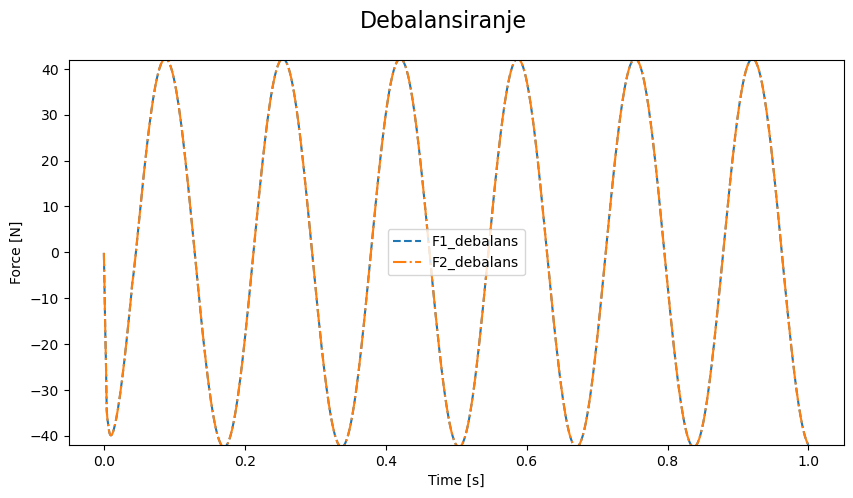

In [115]:
filename = 'meritve2/debalans22.txt'
data = open_txt_file(filename)

Time = data[0]
t = Time
F1_debalans = data[1]
F2_debalans = data[2]

def print_data(data, Title, y1=-42, y2=42):
    '''data ima obliko [t, F1, F2]'''
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle(Title, fontsize=16)
    ax.plot(data[0], data[1], '--', label='F1_debalans')
    ax.plot(data[0], data[2], '-.', label='F2_debalans')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Force [N]')
    ax.set_ylim(y1, y2)
    ax.legend();

data_debalans = open_txt_file(filename)
data_debalans[1] = data_debalans[1] - np.mean(data_debalans[1])
data_debalans[2] = data_debalans[2] - np.mean(data_debalans[2])
print_data(data_debalans, Title='Debalansiranje')


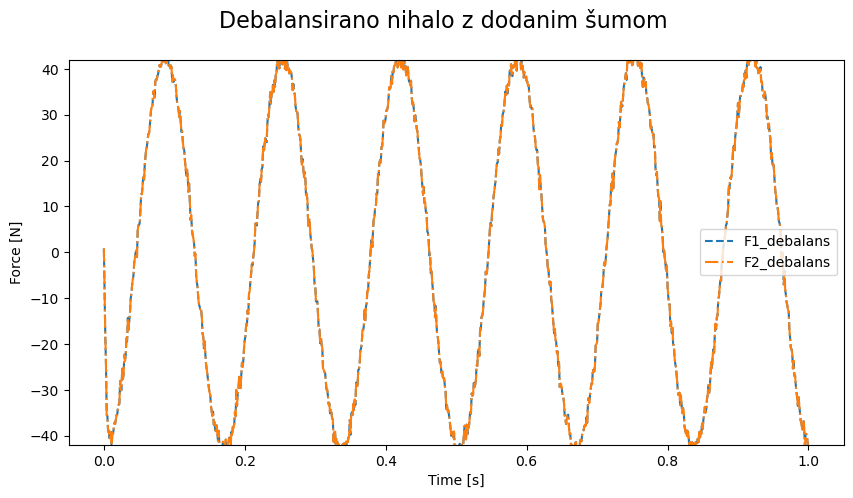

In [116]:
noise_amplitude = 1.2;
noise = np.random.normal(scale=noise_amplitude, size=len(t))
data_debalans_noise = data_debalans.copy()
data_debalans_noise[1] = data_debalans[1] + noise
data_debalans_noise[2] = data_debalans[2] + noise

print_data(data_debalans_noise, Title='Debalansirano nihalo z dodanim šumom')

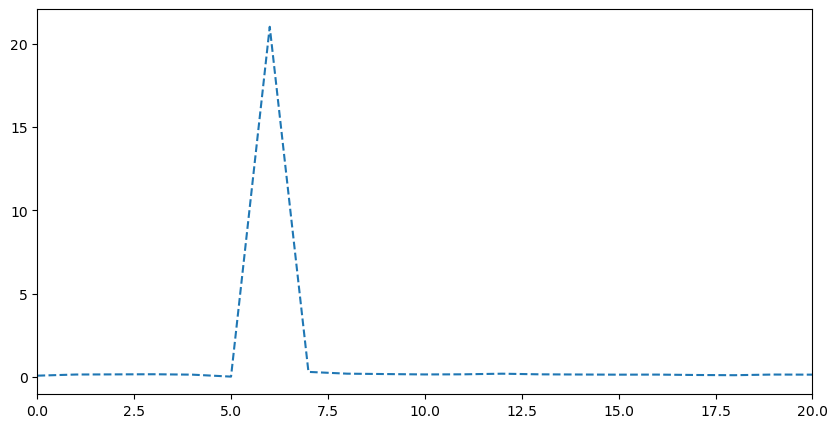

In [117]:
def Fourier(data):
    dt = data[0][1] - data[0][0]
    freq = np.fft.rfftfreq(len(data[0]), dt)
    Fourier_data = np.fft.rfft(data[1], norm="forward");

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(freq, np.abs(Fourier_data), '--')
    ax.set_xlim(0, 20)
    # freq
Fourier(data_debalans_noise)

In [118]:
# freq_F = 6;
# sos = signal.butter(3, [0.95*freq_F, 1.05*freq_F], 'bandpass', fs=1001, output='sos')
# filtriran_debalans = data_debalans.copy()
# filtriran_debalans[1] = signal.sosfiltfilt(sos, data_debalans_noise[1])#*np.hanning(len(Time)))
# filtriran_debalans[2] = signal.sosfiltfilt(sos, data_debalans_noise[2]*np.hanning(len(Time)))

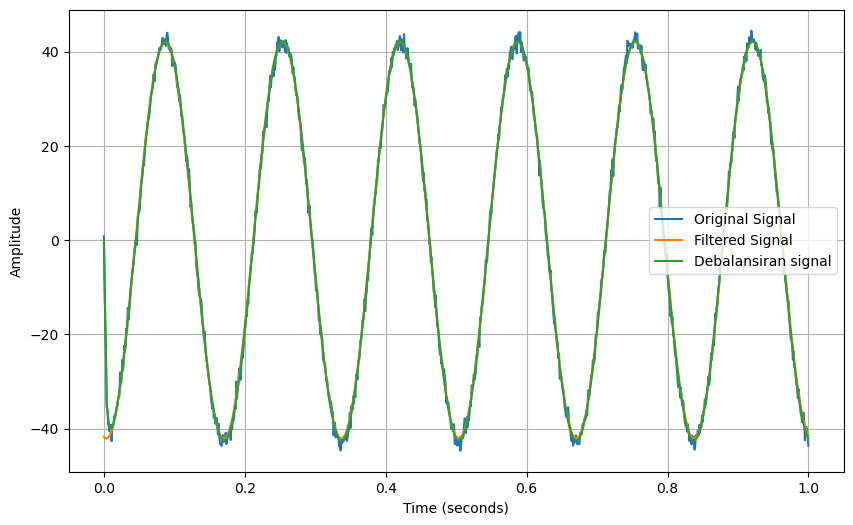

In [119]:
def filtriranje(sampling_rate, t, original_signal, low_cutoff_freq=5.7, high_cutoff_freq=6.3):
    sampling_rate = 1000
    time = t

    # Step 1: Compute the FFT of the original signal
    fft_signal = np.fft.fft(original_signal)

    # Step 2: Apply a frequency-domain filter (e.g., zero out frequencies outside a specific range)
    # Design the frequency domain filter (e.g., band-pass filter)
    freq_range = (low_cutoff_freq, high_cutoff_freq)
    filtered_fft_signal = np.copy(fft_signal)
    freqs = np.fft.fftfreq(len(fft_signal), d=1/sampling_rate)
    filtered_fft_signal[(freqs < freq_range[0]) | (freqs > freq_range[1])] = 0

    # Step 3: Compute the Inverse FFT to get the filtered signal in the time domain
    filtered_signal = 2*np.fft.ifft(filtered_fft_signal)
    return filtered_signal

filtered_signal = filtriranje(sampling_rate, t=t, original_signal=data_debalans_noise[1], low_cutoff_freq=5.7, high_cutoff_freq=6.3)
# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
plt.plot(time, data_debalans_noise[1], label='Original Signal')
plt.plot(time, filtered_signal.real, label='Filtered Signal')
plt.plot(time, data_debalans[1], label='Debalansiran signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



In [120]:
def find_and_print_peaks(signal_array, min_peak_distance=50):
    peaks, _ = signal.find_peaks(signal_array, distance=min_peak_distance)
    # print("Peaks found at indices:", peaks)
    return peaks

peaks = find_and_print_peaks(filtered_signal, min_peak_distance=50)

def amplitude_and_phase(signal_array, peaks):
    amplitude = np.average(np.abs(signal_array[peaks]))
    dif = []
    for i in np.arange(len(peaks)-1):
        dif.append(peaks[i+1]-peaks[i])
    phase = peaks[0]/np.average(dif) * 360
    print(f'Amplituda debalans = {amplitude:.3f} N')
    print(f'Faza debalans = {faza:.3f} stopinj')
    return amplitude, phase

amplitude_v, phase_v = amplitude_and_phase(filtered_signal, peaks)
# Example usage with a cleaner signal
# cleaner_signal = filtered_signal
# min_peak_distance = 50  # Set the minimum peak distance as needed

# peaks = find_and_print_peaks(cleaner_signal, min_peak_distance)
# peaks2 = find_and_print_peaks(data_debalans[1], min_peak_distance)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(t, data_debalans[1], label='Original Signal')
# ax.plot(t, filtered_signal.real, label='Filtered Signal')
# ax.plot(t[peaks], filtered_signal[peaks].real, 'x', label='Detected Peaks_filtered')
# ax.plot(t[peaks2], data_debalans[1][peaks2], 'x', label='Detected Peaks_original')
# ax.set_xlabel('Time')
# ax.set_ylabel('Amplitude')
# ax.legend()
# ax.grid(True)


Amplituda debalans = 42.077 N
Faza debalans = 187.770 stopinj


c:\Users\marko\anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


### Testna masa

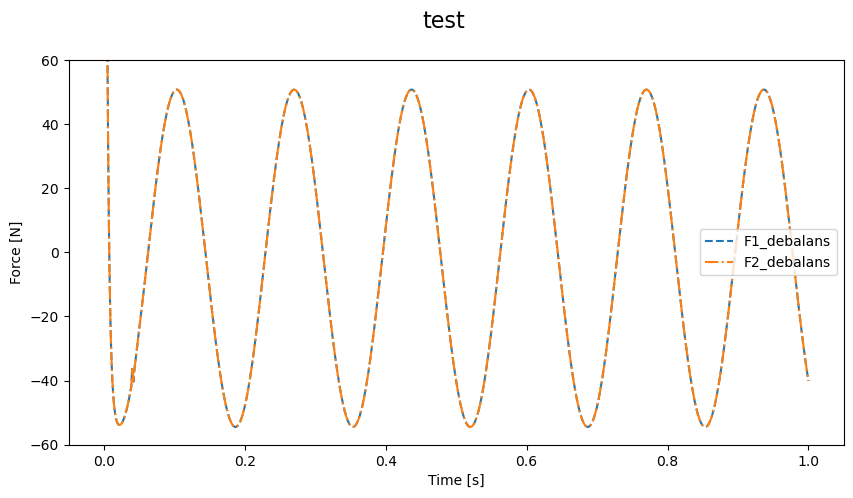

In [121]:
filename = 'meritve2/test22.txt'
data = open_txt_file(filename)

Time = data[0]
t = Time
F1_debalans = data[1]
F2_debalans = data[2]

data_test = open_txt_file(filename)
data_test[1] = data_test[1] - np.mean(data_test[1])
data_test[2] = data_test[2] - np.mean(data_test[2])
print_data(data_test, Title='test', y1=-60, y2=60)



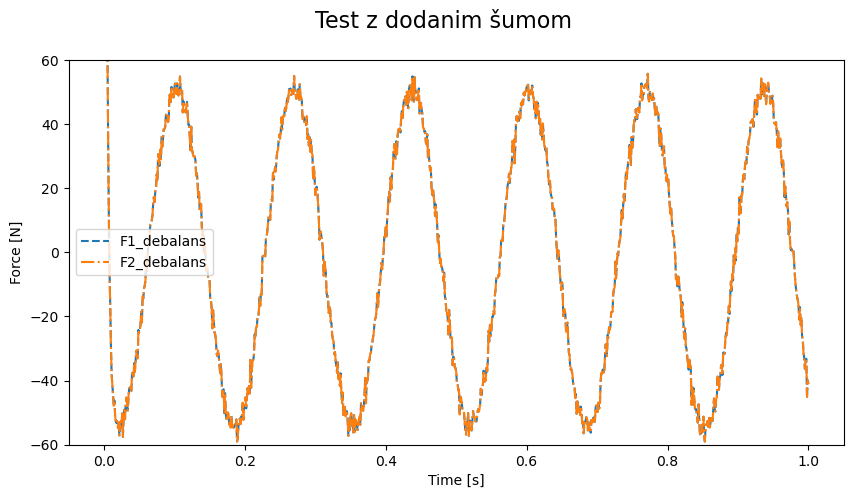

In [122]:
noise_amplitude = 2.2;
noise = np.random.normal(scale=noise_amplitude, size=len(t))
data_test_noise = data_test.copy()
data_test_noise[1] = data_test[1] + noise
data_test_noise[2] = data_test[2] + noise

print_data(data_test_noise, Title='Test z dodanim šumom', y1=-60, y2=60)

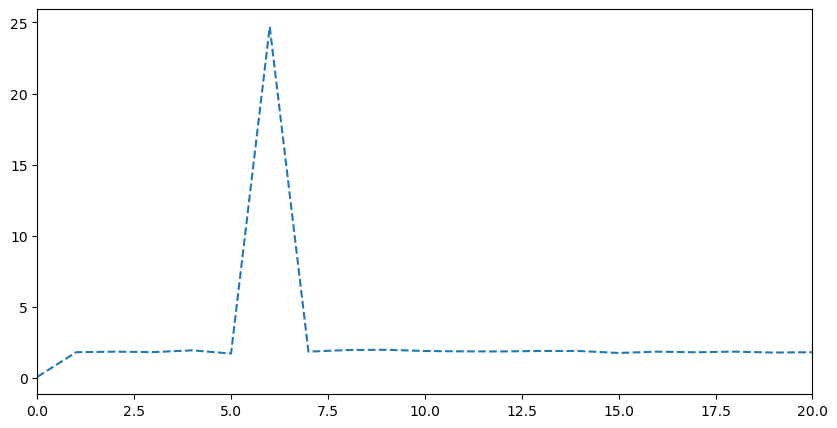

In [123]:
Fourier(data_test_noise)

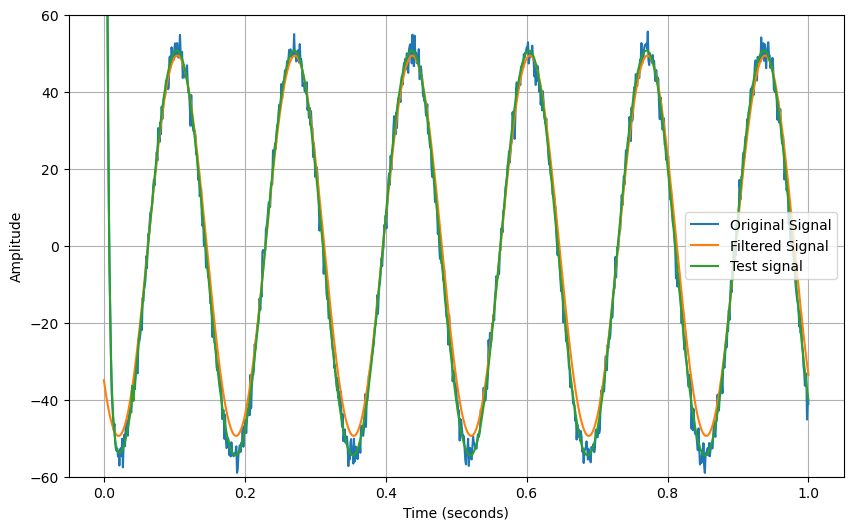

In [124]:
filtered_signal = filtriranje(sampling_rate, t=t, original_signal=data_test_noise[1], low_cutoff_freq=5.7, high_cutoff_freq=6.3)
# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
plt.plot(time, data_test_noise[1], label='Original Signal')
plt.plot(time, filtered_signal.real, label='Filtered Signal')
plt.plot(time, data_test[1], label='Test signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.ylim([-60, 60])
plt.legend()
plt.grid(True)
plt.show()

In [125]:
def find_and_print_peaks(signal_array, min_peak_distance=50):
    peaks, _ = signal.find_peaks(signal_array, distance=min_peak_distance)
    # print("Peaks found at indices:", peaks)
    return peaks

peaks = find_and_print_peaks(filtered_signal, min_peak_distance=50)

def amplitude_and_phase(signal_array, peaks):
    amplitude = np.average(np.abs(signal_array[peaks]))
    dif = []
    for i in np.arange(len(peaks)-1):
        dif.append(peaks[i+1]-peaks[i])
    phase = peaks[0]/np.average(dif) * 360
    print(f'Amplituda debalans = {amplitude:.3f} N')
    print(f'Faza debalans = {phase:.3f} stopinj')
    return amplitude, phase

amplitude_vw, phase_vw = amplitude_and_phase(filtered_signal, peaks)

Amplituda debalans = 49.396 N
Faza debalans = 224.460 stopinj


### Izračun korekcije

${A_w}^2 = {A_{v+w}}^2 + {A_v}^2 - 2 A_v A_{v+w} \cdot cos(\alpha)$

In [137]:
alpha1 = phase_v - phase_vw
A_w = np.sqrt(amplitude_vw**2 + amplitude_v**2 - 2*amplitude_vw*amplitude_v*np.cos(alpha1))
A_w, amplitude_vw, amplitude_v, alpha1

(44.65614566657909, 49.39611647628715, 42.077184941782384, -36.690647482014384)

In [142]:
amplitude_v**2 + A_w**2 - amplitude_vw**2, 2*amplitude_v*A_w

(1324.684515480762, 3758.009799999645)

In [146]:
alpha2_arccos = (amplitude_v**2 + A_w**2 - amplitude_vw**2)/(2*amplitude_v*A_w)
alpha2 = np.arccos(alpha2_arccos)
alpha2*180/np.pi

69.35992436152857

### Korekcijska masa

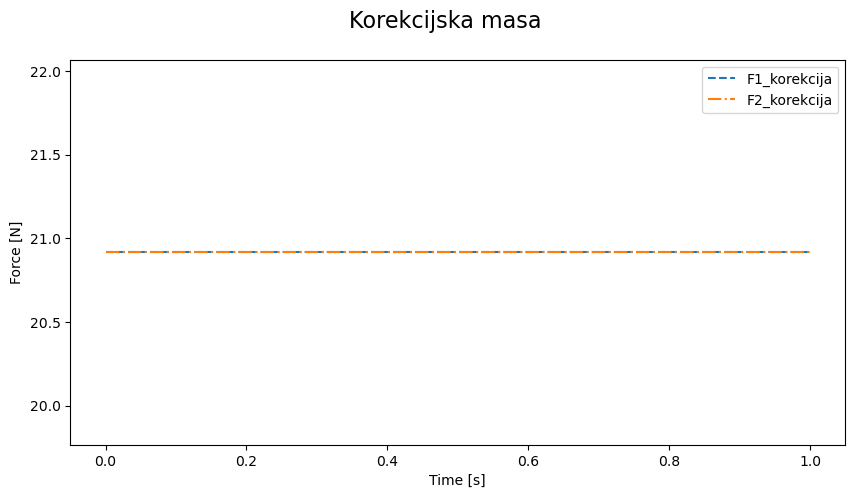

In [ ]:

# Initialize empty lists for each column
column1_data = []
column2_data = []
column3_data = []

# Open the file for reading
with open('meritve/Meritev_korekcijska_masa.txt', 'r') as file:

    # Skip the first 8 lines
    for _ in range(8):
        next(file)

    # Read the remaining lines and extract data from the columns
    for line in file:
        columns = line.strip().split()
        if len(columns) == 3:
            column1_data.append(float(columns[0].strip()))
            column2_data.append(float(columns[1].strip()))
            column3_data.append(float(columns[2].strip()))

# Convert the lists to NumPy arrays
column1_array = np.array(column1_data)
column2_array = np.array(column2_data)
column3_array = np.array(column3_data)

# Now you have the data in NumPy arrays
# print("Column 1:", column1_array)
# print("Column 2:", column2_array)
# print("Column 3:", column3_array)

Time = np.array(column1_data)
F1_korekcija = np.array(column2_data)
F2_korekcija = np.array(column3_data)

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Korekcijska masa', fontsize=16)
ax.plot(Time, F1_korekcija, '--', label='F1_korekcija')
ax.plot(Time, F2_korekcija, '-.', label='F2_korekcija')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Force [N]')
ax.legend();


ValueError: x and y must have same first dimension, but have shapes (101,) and (1001,)

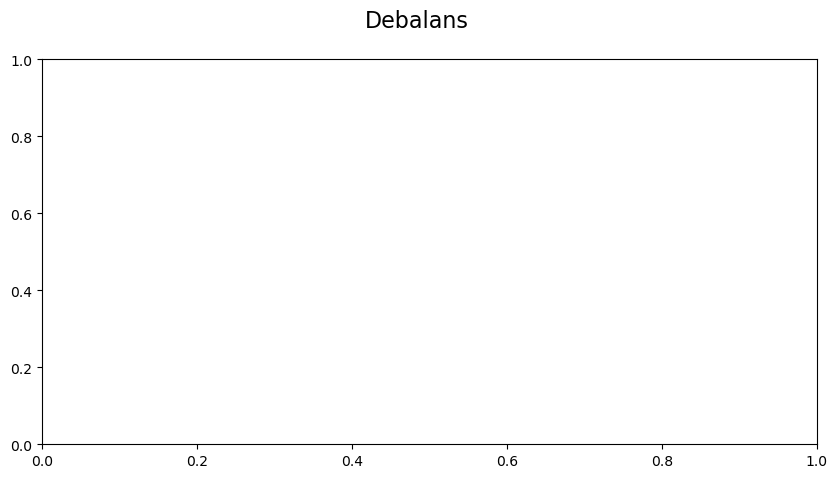

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Debalans', fontsize=16)
ax.plot(Time, F1_debalans, '--', label='F1_debalans')
ax.plot(Time, F1_testna, '--', label='F1_testna')
ax.plot(Time, F1_korekcija, label='F1_korekcija')
ax.set_xlim(0, 1)
ax.set_ylim(-10, 50)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Force [N]')
ax.legend();


In [ ]:
F1_debalans

array([17.97423  , -0.2162177,  0.8495509,  3.419235 ,  6.71389  ,
       10.78399  , 15.00695  , 19.77603  , 24.51086  , 28.87934  ,
       32.02705  , 34.73961  , 36.29417  , 36.70787  , 35.96244  ,
       34.09688  , 31.22898  , 27.53703  , 23.21249  , 18.67619  ,
       13.99258  ,  9.59285  ,  5.669006 ,  2.590944 ,  0.4428073,
       -0.641651 , -0.5558282,  0.6891136,  3.003696 ,  6.245849 ,
       10.21876  , 14.67522  , 19.33637  , 23.9123   , 28.11914  ,
       31.69542  , 34.41855  , 36.11919  , 36.69165  , 36.10039  ,
       34.38212  , 31.64368  , 28.05534  , 23.8402   , 19.26035  ,
       14.60053  , 10.15046  ,  6.186844 ,  2.956104 ,  0.659116 ,
       -0.5613034, -0.6292748,  0.4594281,  2.637115 ,  5.768388 ,
        9.658559 , 14.06576  , 18.71596  , 23.32005  , 27.59176  ,
       31.26549  , 34.11284  , 35.95677  , 36.68262  , 36.24528  ,
       34.67193  , 32.0604   , 28.57306  , 24.42673  , 19.87921  ,
       15.21325  , 10.71896  ,  6.675756 ,  3.335038 ,  0.9045

In [ ]:
len(Time)

101

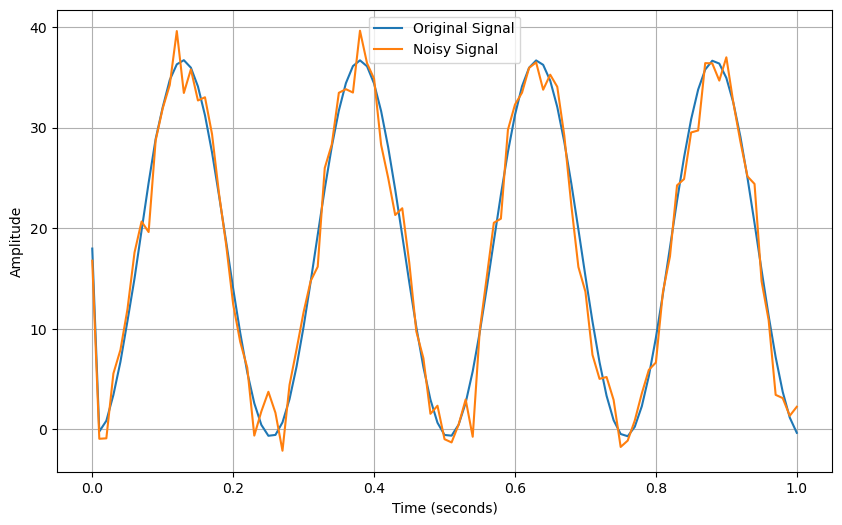

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def add_noise_to_signal(signal, noise_amplitude):
    noise = np.random.normal(scale=noise_amplitude, size=len(signal))
    return signal + noise

def apply_low_pass_filter(signal, cutoff_freq, sampling_rate):
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = signal.butter(4, normalized_cutoff, btype='low')
    filtered_signal = signal.filtfilt(b, a, signal, padtype='even')
    return filtered_signal

# Assuming you have the original signal as an array of numbers
original_signal = F1_debalans

# Define the parameters for noise and filtering
noise_amplitude = 2  # Adjust this value to control the amount of noise
cutoff_frequency = 5.0  # Adjust this value to control the cutoff frequency of the low-pass filter
sampling_rate = 100  # Adjust this value to match the sampling rate of your signal

# Add noise to the original signal
noisy_signal = add_noise_to_signal(original_signal, noise_amplitude)

# Apply a low-pass filter to the noisy signal
# filtered_signal = apply_low_pass_filter(noisy_signal, cutoff_frequency, sampling_rate)

# Plot the original, noisy, and filtered signals
time = np.arange(len(original_signal)) / sampling_rate

plt.figure(figsize=(10, 6))
plt.plot(time, original_signal, label='Original Signal')
plt.plot(time, noisy_signal, label='Noisy Signal')
# plt.plot(time, filtered_signal, label='Filtered Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
